<a href="https://colab.research.google.com/github/chohan3036/supply_smp_predict/blob/master/supply_smp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

멀티캠퍼스 4조 - 제주도의 전력 사용량 및 SMP 예측

* S-ARIMA 파트가 git 상에서 정상적으로 로드 되지 않아 주석 처리 해놓았습니다.

## 1. 라이브러리 및 데이터

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os 
os.chdir('/content/drive/MyDrive/멀티캠퍼스_프로젝트')
import numpy as np
import pandas as pd
import tensorflow as tf
import random as rd

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno    # 결측치 확인
from statsmodels.tsa.seasonal import seasonal_decompose     # 시계열 분해
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf   # SARIMA 모델의 파라미터 결정

# 모델 평가
from sklearn.metrics import mean_squared_error, r2_score

# SARIMA 모델
# !pip install pmdarima
# from pmdarima.arima import auto_arima

# Prophet 모델
!pip install prophet
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

# RNN 모델
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D
import keras.backend as K 
from keras.callbacks import EarlyStopping

# LightGBM 모델 및 베이지안 최적화
import lightgbm as lgb
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

In [ ]:
target = pd.read_csv('target.csv')
target.head(5)

,date,smp_max,smp_min,smp_mean,supply
0,2018-02-01,150.65,116.84,132.71,87.47
1,2018-02-02,163.86,116.84,134.19,86.64
2,2018-02-03,164.07,116.85,131.39,88.28
3,2018-02-04,171.00,115.76,131.89,86.14
4,2018-02-05,170.34,123.89,137.96,90.63


In [ ]:
weather = pd.read_csv('weather.csv')
weather.head(5)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.



,area,datetime,temp,temp_QCFlag,prec,prec_QCFlag,ws,ws_QCFlag,wd,wd_QCFlag,humid,humid_QCFlag,vaporP,dew,landP,landP_QCFlag,seaP,seaP_QCFlag,suntime,suntime_QCFlag,rad,snow,3hr_snow,C,lowmiddleC,typeC,ceiling,vis,sfctype,weathernumber,sfctemp,sfctemp_QCFlag,landtemp_5cm,landtemp_10cm,landtemp_20cm,landtemp_30cm,station
0,184,2018-02-01 01:00,4.7,0.0,NaN,NaN,3.6,0.0,20.0,0.0,58.0,0.0,5.0,-2.8,1024.4,0.0,1027.0,0.0,NaN,9.0,NaN,NaN,NaN,NaN,9.0,NaN,12.0,1950.0,NaN,NaN,2.9,0.0,3.7,3.9,4.2,4.9,ASOS
1,184,2018-02-01 02:00,4.8,0.0,NaN,NaN,2.6,0.0,360.0,0.0,57.0,0.0,4.9,-3.0,1024.3,0.0,1026.9,0.0,NaN,9.0,NaN,NaN,NaN,NaN,10.0,NaN,NaN,1865.0,NaN,NaN,2.9,0.0,3.6,3.8,4.2,4.9,ASOS
2,184,2018-02-01 03:00,4.8,0.0,NaN,NaN,4.6,0.0,20.0,0.0,62.0,0.0,5.4,-1.8,1024.1,0.0,1026.7,0.0,NaN,9.0,NaN,NaN,NaN,9.0,9.0,Sc,11.0,1855.0,NaN,NaN,3.0,0.0,3.6,3.8,4.3,4.9,ASOS
3,184,2018-02-01 04:00,4.5,0.0,NaN,NaN,5.7,0.0,20.0,0.0,62.0,0.0,5.2,-2.1,1023.8,0.0,1026.4,0.0,NaN,9.0,NaN,NaN,NaN,8.0,8.0,Sc,9.0,1425.0,NaN,NaN,3.0,0.0,3.6,3.8,4.2,5.0,ASOS
4,184,2018-02-01 05:00,4.5,0.0,NaN,9.0,4.4,0.0,20.0,0.0,62.0,0.0,5.2,-2.1,1023.8,0.0,1026.4,0.0,NaN,9.0,NaN,NaN,NaN,9.0,9.0,Sc,10.0,1043.0,NaN,1.0,3.0,0.0,3.5,3.8,4.2,4.9,ASOS


## 2. 사용할 지점 및 기상 속성과 그 이유

1. 지점
    - 사용할 지점 : 제주, 고산, 성산, 서귀포 (ASOS 지점)
    - 이유 : 전국적으로 ASOS에서 관측한 기온이 공식으로 인정 받기 때문이다.

2. 기상 속성
    - 사용할 속성 : 기온 (최저, 최고, 평균)
    - 이유 : 주어진 속성 중에 결측치가 적고 상관계수가 높은 편에 속하기 때문이다.

### 선정한 기상 속성의 타당성 알아보기

결측치 확인 결과, `temp, ws, wd, humid` 의 결측치가 가장 적음

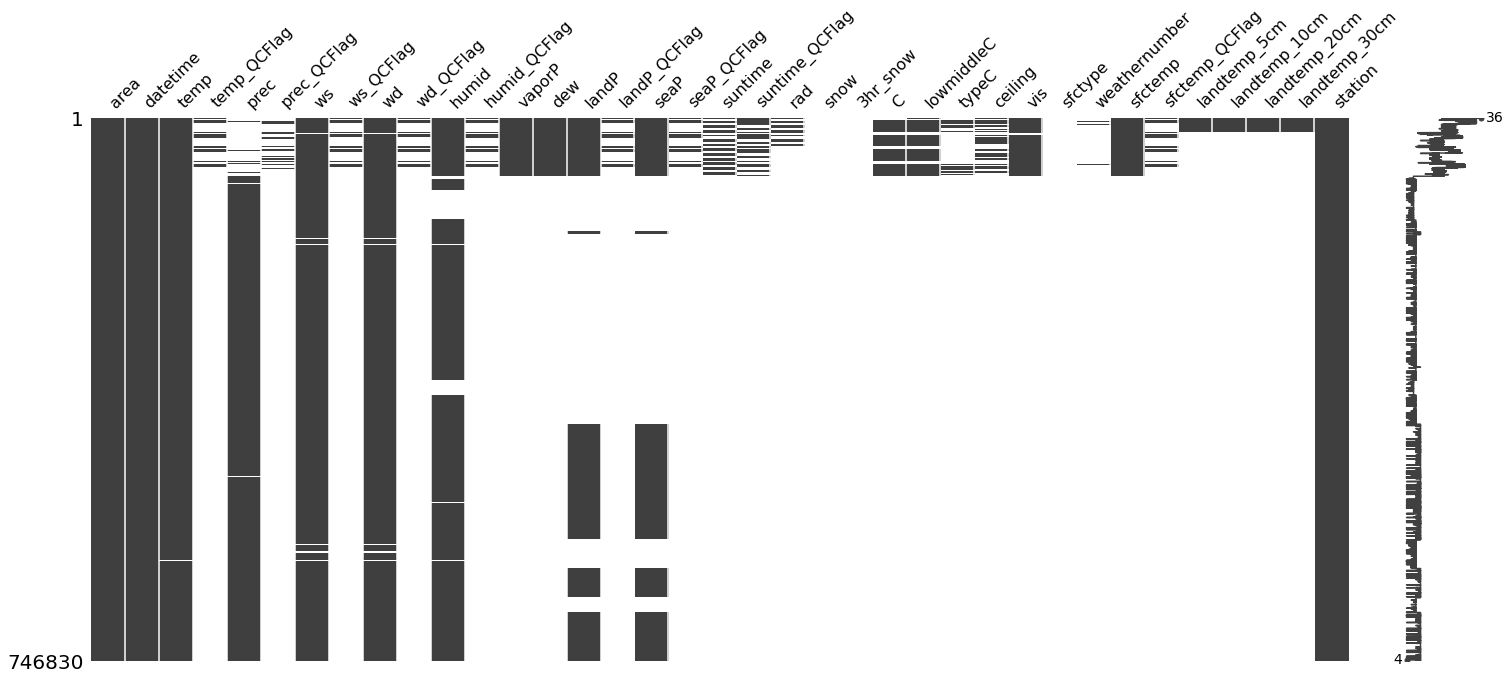

In [ ]:
msno.matrix(weather)
plt.show()

`supply`/`smp` 와의 상관관계를 알아보기 위해 `weather_mean`이라는 일자별 기상 통계 dataFrame을 만듦

In [ ]:
weather['date'] = weather['datetime'].apply(lambda x: x[:10]) # 일자만 취하기
weather_mean = weather.groupby('date').mean().reset_index(drop=True)
weather_mean.drop('area', axis=1, inplace=True)
weather_mean

,temp,temp_QCFlag,prec,prec_QCFlag,ws,ws_QCFlag,wd,wd_QCFlag,humid,humid_QCFlag,vaporP,dew,landP,landP_QCFlag,seaP,seaP_QCFlag,suntime,suntime_QCFlag,rad,snow,3hr_snow,C,lowmiddleC,ceiling,vis,sfctype,weathernumber,sfctemp,sfctemp_QCFlag,landtemp_5cm,landtemp_10cm,landtemp_20cm,landtemp_30cm
0,1.271798,0.0,0.003444,8.100000,3.523141,0.0,175.879137,0.0,67.423452,0.0,4.989130,-2.901087,977.602813,0.000000,1029.139642,0.000000,0.554167,4.304348,0.684583,NaN,NaN,6.352941,6.347826,16.090909,1552.097826,NaN,689.666667,4.636957,0.0,4.186957,4.134783,4.426087,4.995652
1,0.419820,0.0,0.000000,9.000000,3.852709,0.0,216.583973,0.0,57.458586,0.0,4.433333,-4.551042,978.190686,0.000000,1029.866912,0.000000,0.385417,4.500000,0.857500,NaN,NaN,6.722222,3.666667,24.888889,1988.760417,NaN,NaN,4.097917,0.0,3.879167,3.933333,4.433333,5.191667
2,-1.787600,0.0,0.289295,7.024390,5.602110,0.0,269.011723,0.0,76.501677,0.0,4.533333,-4.243750,977.089770,0.010417,1030.187724,0.010417,0.191667,4.500000,0.292500,1.053846,0.100000,8.909091,8.208333,6.250000,1427.197917,NaN,136.750000,2.410417,0.0,3.441667,3.766667,4.362500,5.337500
3,-3.873874,0.0,0.270012,6.483871,5.975114,0.0,273.509932,0.0,79.000126,0.0,4.076042,-5.517708,977.746569,0.000000,1030.341667,0.000000,0.254167,4.500000,0.445417,1.656452,0.614286,8.833333,8.833333,4.625000,1330.406250,NaN,39.583333,1.398958,0.0,2.612500,2.979167,3.670833,4.933333
4,-2.729229,0.0,0.243742,6.656250,5.134080,0.0,269.770637,0.0,77.278655,0.0,4.305208,-4.848958,976.482598,0.000000,1028.782108,0.000000,0.318750,4.500000,0.453750,5.217460,0.537500,8.708333,8.708333,3.708333,1355.822917,NaN,8.000000,1.659375,0.0,2.362500,2.695833,3.350000,4.591667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,16.911513,NaN,0.000000,NaN,3.341164,NaN,146.815038,NaN,54.062738,NaN,12.135417,9.042708,976.423904,NaN,1017.842325,NaN,0.471667,9.000000,1.364667,NaN,NaN,6.187500,3.312500,45.535714,1983.833333,NaN,NaN,21.121875,NaN,20.137500,20.795833,20.370833,19.833333
834,18.643202,NaN,1.988746,9.000000,3.897588,NaN,173.301864,NaN,92.253810,NaN,21.136458,18.310417,967.743213,NaN,1009.840045,NaN,0.048333,9.000000,0.578000,NaN,NaN,9.593750,7.343750,7.787879,868.489583,NaN,18543.187500,20.453125,NaN,20.762500,21.425000,20.795833,20.116667
835,17.191510,NaN,0.168819,9.000000,1.884323,NaN,199.394625,NaN,91.198443,NaN,19.356250,16.922917,966.255102,NaN,1008.270748,NaN,0.073333,9.000000,0.596667,NaN,NaN,9.395833,8.010417,5.868852,306.729167,NaN,16953.936170,20.636458,NaN,20.641667,21.283333,20.850000,20.358333
836,16.407675,NaN,0.000000,9.000000,1.934122,NaN,162.449099,NaN,80.912143,NaN,17.764583,15.565625,966.537061,NaN,1007.336842,NaN,0.453333,9.000000,1.369667,NaN,NaN,8.104167,4.937500,12.363636,925.260417,NaN,7313.703704,21.482292,NaN,20.408333,21.045833,20.558333,20.125000


`target`과 생성된 `weather_mean`을 concat 하여 heatmap 으로 상관관계를 나타냄


그 결과, 위에서 고른 세 속성 중 `temp`의 상관계수가 가장 높은 것을 확인

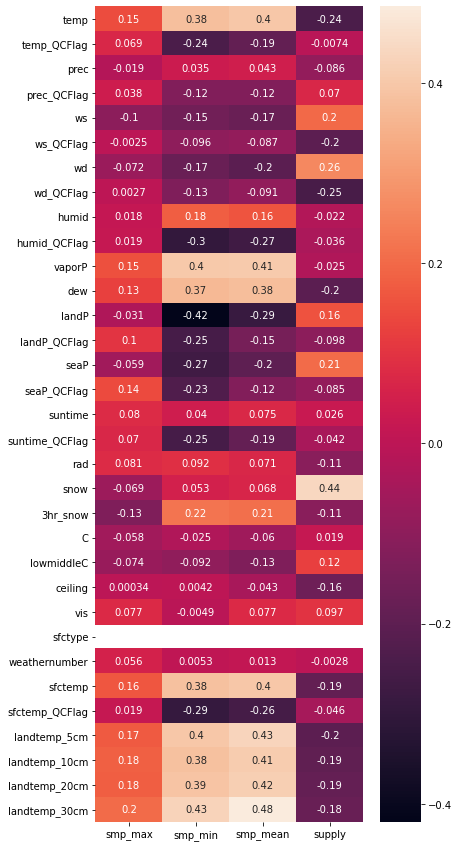

In [ ]:
corr_df = pd.concat([target, weather_mean], axis=1)
plt.figure(figsize=(6, 15))
sns.heatmap(corr_df.corr().iloc[4:,:4], annot=True)
plt.show()

## 3. 데이터 전처리

`station == 'ASOS'` 인 데이터만 취해, 지정한 네 지점만 고려함

`temp` 이외의 기상 속성 또한 `drop` 함

In [ ]:
weather = weather[weather['station'] == 'ASOS'] # ASOS 관측 기상 정보가 가장 신뢰도 높기 때문에
weather = weather.loc[:, 'area':'temp']
weather

,area,datetime,temp
0,184,2018-02-01 01:00,4.7
1,184,2018-02-01 02:00,4.8
2,184,2018-02-01 03:00,4.8
3,184,2018-02-01 04:00,4.5
4,184,2018-02-01 05:00,4.5
...,...,...,...
80427,189,2020-05-18 19:00,19.0
80428,189,2020-05-18 20:00,19.8
80429,189,2020-05-18 21:00,18.9
80430,189,2020-05-18 22:00,18.1


결측치는 1시간 전의 온도로 대체함

In [ ]:
print(weather.isna().sum(), '\n')
weather.fillna(method='ffill', inplace=True)
print(weather.isna().sum())

area         0
datetime     0
temp        45
dtype: int64 

area        0
datetime    0
temp        0
dtype: int64


datetime으로 `groupby`하여 지점별 `temp`의 평균을 산출

In [ ]:
temp_mean = weather.groupby('datetime').mean().reset_index()['temp']
temp_hour = pd.DataFrame({'temp_mean': temp_mean})
temp_hour['date'] = weather['datetime'].apply(lambda x: x[:10])
temp_hour.head(3)

,temp_mean,date
0,3.900,2018-02-01
1,3.850,2018-02-01
2,3.675,2018-02-01


다시 `date`로 `groupby`하여 시간별 데이터를 일자별로 취합함

이때 평균 데이터로부터 다시 평균, 최대, 최소 `temp`를 산출함

In [ ]:
temp_max = temp_hour.groupby('date').max().reset_index()['temp_mean']
temp_min = temp_hour.groupby('date').min().reset_index()['temp_mean']
temp_mean = temp_hour.groupby('date').mean().reset_index()['temp_mean']
temp_date = pd.DataFrame({'temp_max': temp_max,
                          'temp_min': temp_min,
                          'temp_mean': temp_mean})
temp_date.head(3)

,temp_max,temp_min,temp_mean
0,6.300,3.200,4.346739
1,5.625,2.200,3.760417
2,3.800,-0.475,1.337500


최종적으로 `target`과 산출된 `temp_date`를 `concat`하여 모델 구성에 사용할 데이터를 완성

In [ ]:
df = pd.concat([target, temp_date], axis=1)
df['date'] = pd.to_datetime(df['date'])
df

,date,smp_max,smp_min,smp_mean,supply,temp_max,temp_min,temp_mean
0,2018-02-01,150.65,116.84,132.71,87.47,6.300,3.200,4.346739
1,2018-02-02,163.86,116.84,134.19,86.64,5.625,2.200,3.760417
2,2018-02-03,164.07,116.85,131.39,88.28,3.800,-0.475,1.337500
3,2018-02-04,171.00,115.76,131.89,86.14,0.250,-1.900,-1.017708
4,2018-02-05,170.34,123.89,137.96,90.63,1.525,-1.500,-0.077083
...,...,...,...,...,...,...,...,...
833,2020-05-14,193.28,66.78,100.46,62.70,22.325,14.200,18.710417
834,2020-05-15,198.23,61.81,102.38,64.91,21.900,18.525,19.930208
835,2020-05-16,220.91,88.50,121.19,61.75,19.000,15.525,17.560417
836,2020-05-17,207.75,65.78,116.82,61.55,20.100,14.450,17.070833


## 4. 탐색적 자료분석

In [ ]:
sns.set(rc={'figure.figsize':(16, 4)})

SMP 와 supply의 시간에 따른 변화

SMP는 일자별로 변화폭이 큰 구간이 존재하는 반면, supply는 상대적으로 변화폭이 작고 일정함

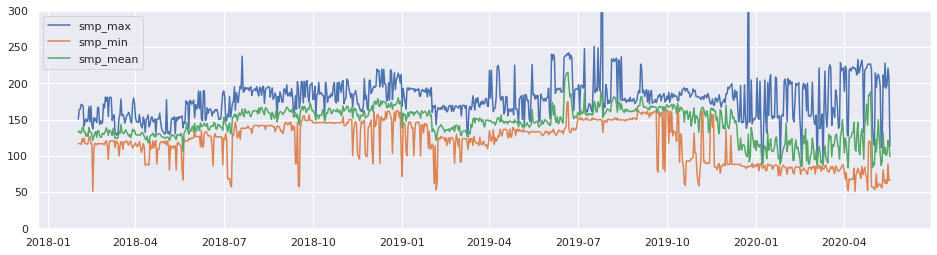

In [ ]:
plt.plot(df['date'], df['smp_max'], label='smp_max')
plt.plot(df['date'], df['smp_min'], label='smp_min')
plt.plot(df['date'], df['smp_mean'], label='smp_mean')
plt.ylim(0,300)
plt.legend()
plt.show()

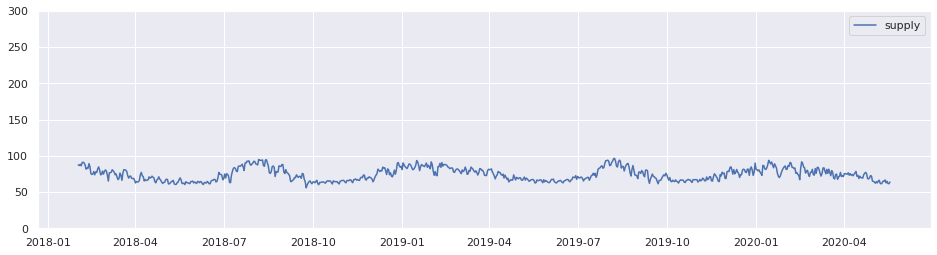

In [ ]:
plt.plot(df['date'], df['supply'], label='supply')
plt.ylim(0,300)
plt.legend()
plt.show()

`smp_mean`과 `temp_mean`의 비교


`smp_mean`은 `temp_mean`에 비해 계절성이 뚜렷하지 않고 변화폭이 큼

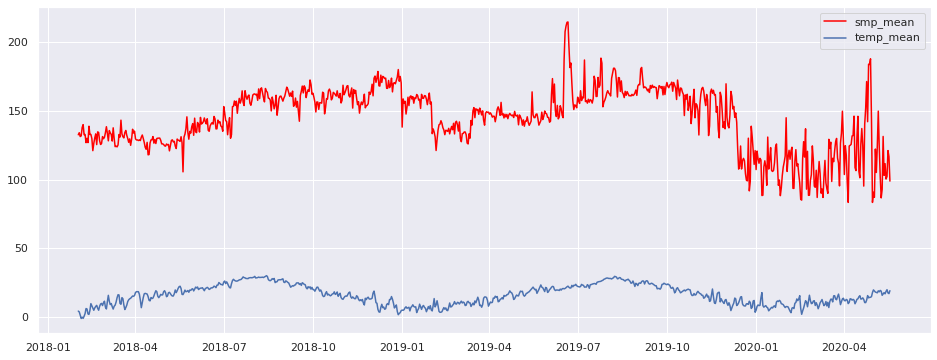

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(df['date'], df['smp_mean'], label='smp_mean', color='red')
plt.plot(df['date'], df['temp_mean'], label='temp_mean')
plt.legend()
plt.show()

`supply`와 `temp_mean`의 비교

두 속성 모두 계절성이 뚜렷하게 드러남

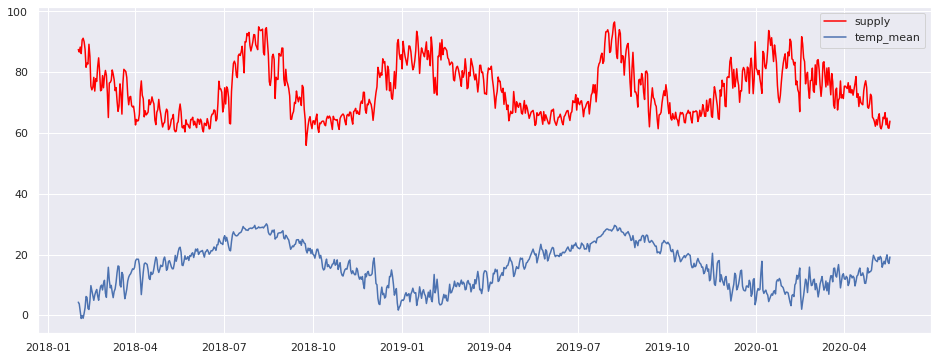

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(df['date'], df['supply'], label='supply', color='red')
plt.plot(df['date'], df['temp_mean'], label='temp_mean')
plt.legend()
plt.show()

월별 비교

In [ ]:
df['month'] = df['date'].dt.month

연도 대비 동월의 값 분포

smp 관련 속성들의 경우, 상대적으로 여름인 6, 7, 8월에 이상치가 많음

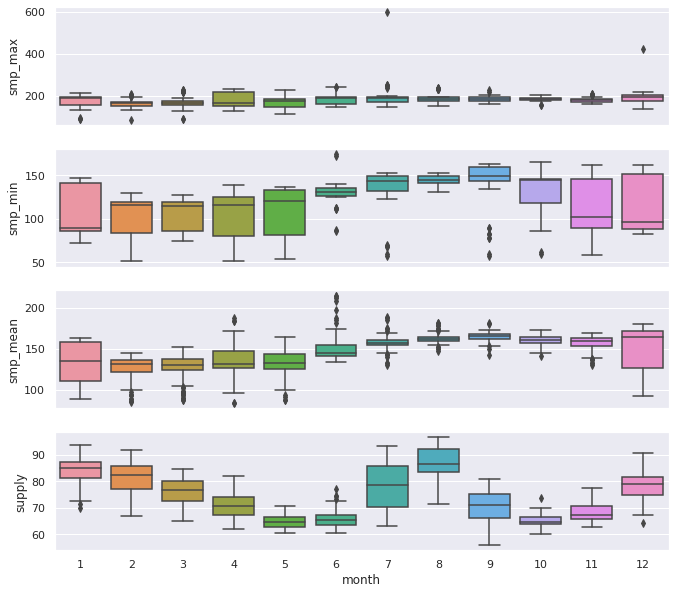

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['smp_max', 'smp_min', 'smp_mean', 'supply'], axes):
    sns.boxplot(data=df, x='month', y=name, ax=ax)
    if ax != axes[-1]:
        ax.set_xlabel('')

temp 관련 속성은 주기성, 계절성이 뚜렷하게 드러남

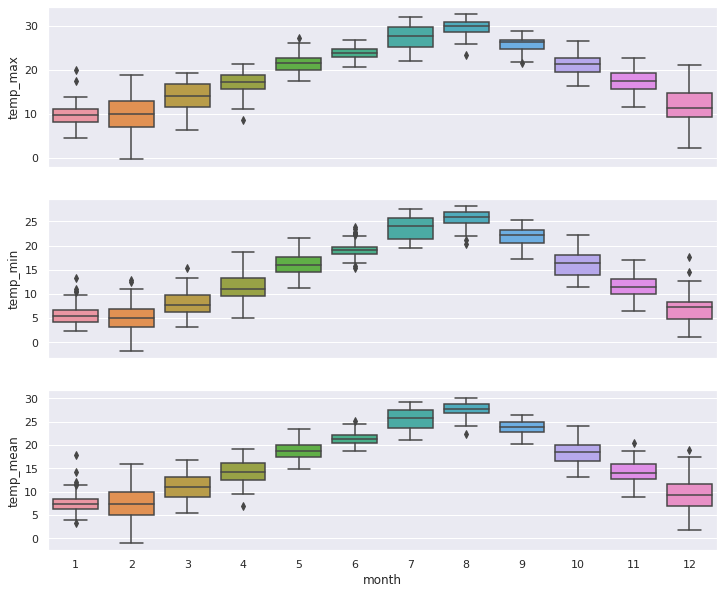

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
for name, ax in zip(['temp_max', 'temp_min', 'temp_mean'], axes):
    sns.boxplot(data=df, x='month', y=name, ax=ax)
    if ax != axes[-1]:
        ax.set_xlabel('')

`supply`와 `smp`, `temp`의 상관관계

`supply`는 `temp`와는 대체적으로 0.5 이상의 큰 상관관계를 보이는 반면, `smp`는 그렇지 않다.

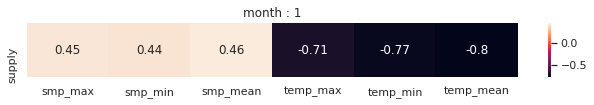

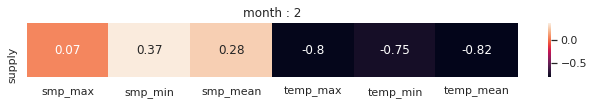

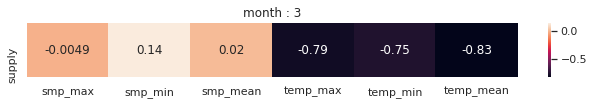

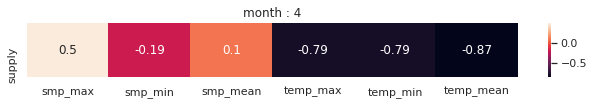

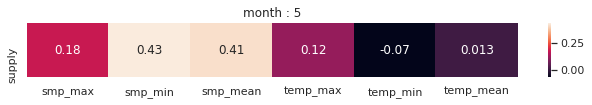

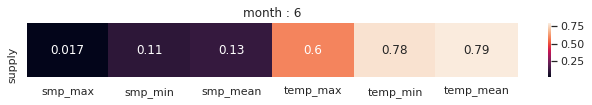

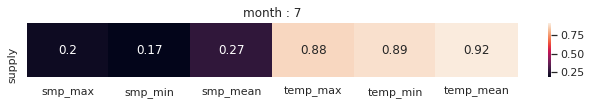

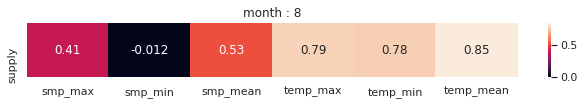

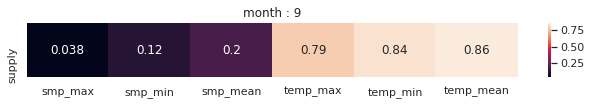

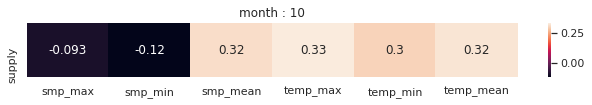

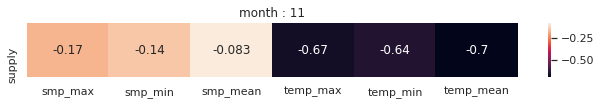

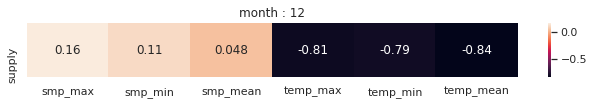

In [ ]:
plt.rcParams['figure.figsize'] = [11, 1]
for m in range(1, 13):
    sns.heatmap(df[df['month'] == m].corr().loc[['supply'],
                                                ['smp_max', 'smp_min', 'smp_mean', 
                                                 'temp_max', 'temp_min', 'temp_mean']], 
                annot=True)
    plt.title('month : '+ str(m))
    plt.show()

`smp`와 `supply`, `temp`의 상관관계

`smp`와 `supply`, `temp`는 1, 2월, 7, 8월의 최저/최고 기온 부분에서 큰 상관관계를 보였다. 이외에는 유의한 상관관계는 살펴볼 수 없었다.

`smp`는 유가, 시장 상황 등 외부 요인의 영향을 받기 때문이다.

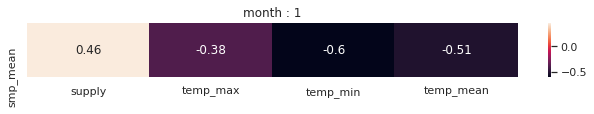

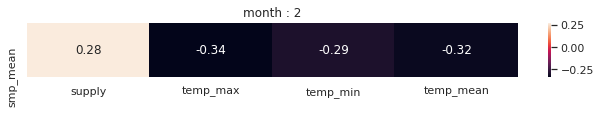

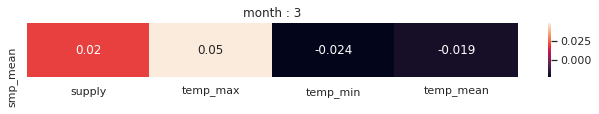

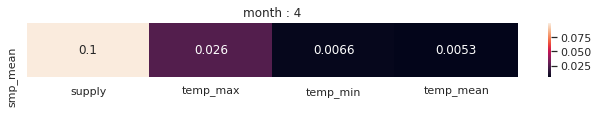

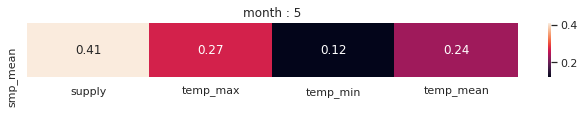

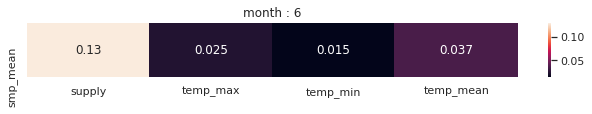

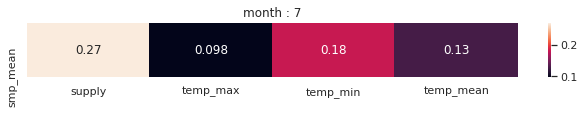

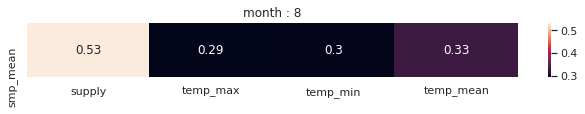

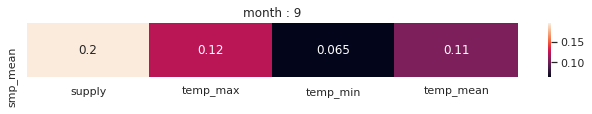

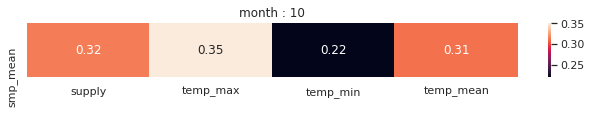

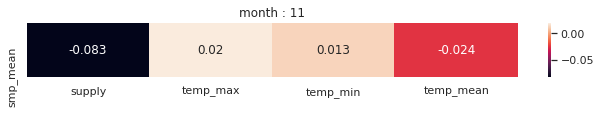

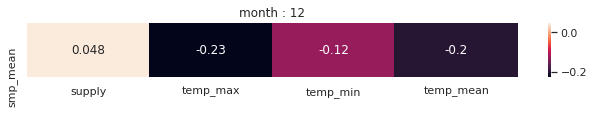

In [ ]:
plt.rcParams['figure.figsize'] = [11, 1]
for m in range(1, 13):
    sns.heatmap(df[df['month'] == m].corr().loc[['smp_mean'],
                                                ['supply', 
                                                 'temp_max', 'temp_min', 'temp_mean']], 
                annot=True)
    plt.title('month : '+ str(m))
    plt.show()

시계열 분해

- Observed : 실제 데이터
- Trend : 데이터의 변화 추세
- Seasonality : 계절성 (1년 기준으로 반복적으로 나타나는 데이터의 변화)
- Residual : 실제 데이터에서 추세와 계절성을 빼고 난 잔차


In [ ]:
df.set_index('date', inplace=True)

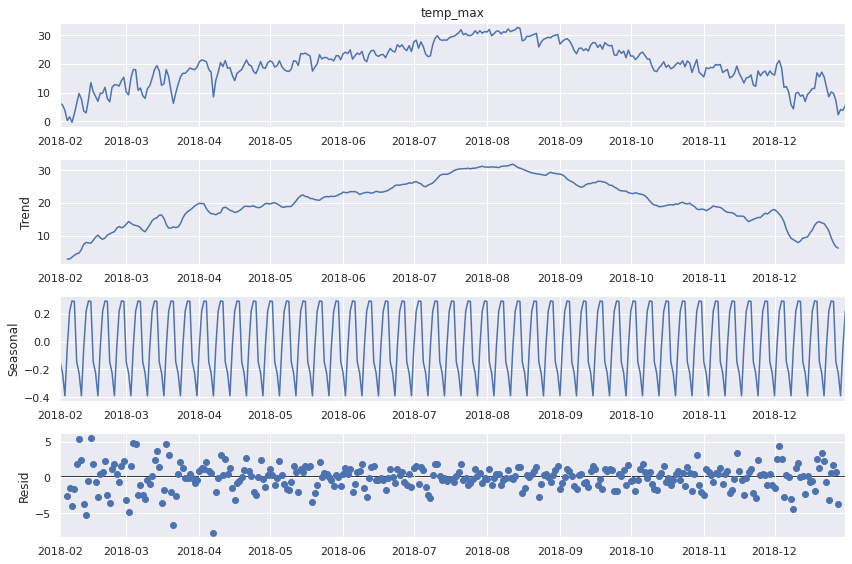

In [ ]:
x = df.loc[df.index.year == 2018, 'temp_max']
dc = seasonal_decompose(x, model='additive')
plt.rcParams['figure.figsize'] = [12, 8]
dc.plot()
plt.show()

#### ACF 와 PACF

SARIMA 모델 구현을 위한 ACF, PACF 확인

차분 횟수에 따른 시각화 결과

- `temp_max`, `diff=0`

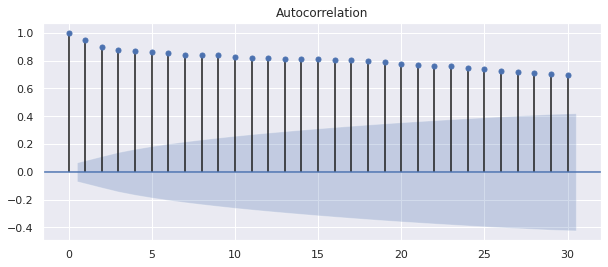

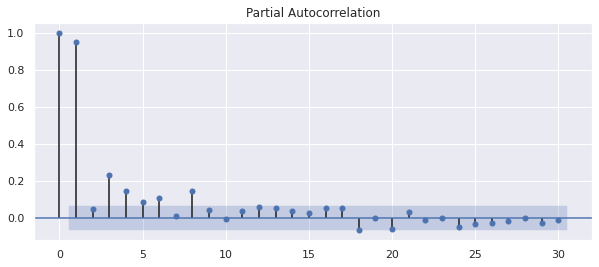

In [ ]:
fig1 = plot_acf(df.temp_max, lags=30)
fig2 = plot_pacf(df.temp_max, lags=30)
fig1.set_size_inches((10, 4))
fig2.set_size_inches((10, 4))
plt.show()

- `temp_max`, `diff=1`

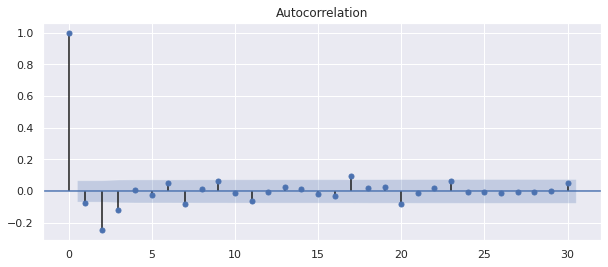

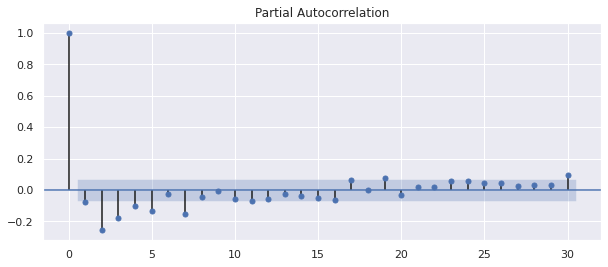

In [ ]:
diff = df.temp_max.diff(periods=1).iloc[1:]
fig1 = plot_acf(diff, lags=30)
fig2 = plot_pacf(diff, lags=30)
fig1.set_size_inches((10, 4))
fig2.set_size_inches((10, 4))
plt.show()

- `temp_min`, `diff=0`

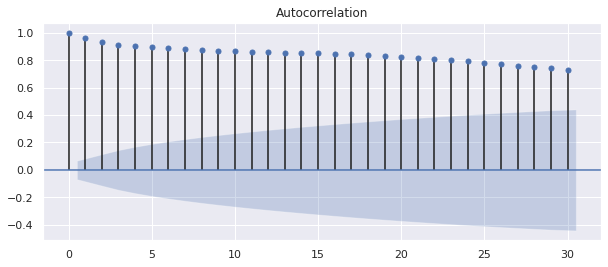

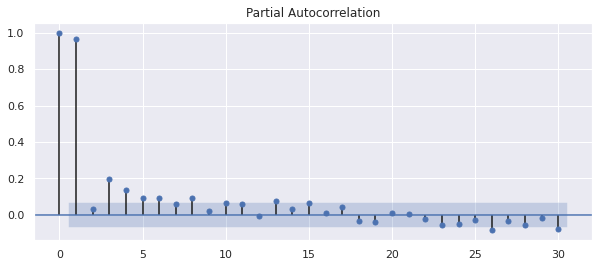

In [ ]:
fig1 = plot_acf(df.temp_min, lags=30)
fig2 = plot_pacf(df.temp_min, lags=30)
fig1.set_size_inches((10, 4))
fig2.set_size_inches((10, 4))
plt.show()

- `temp_min`, `diff=1`

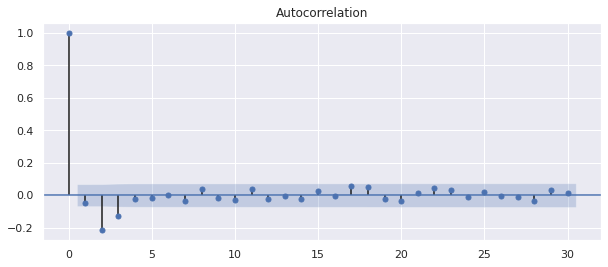

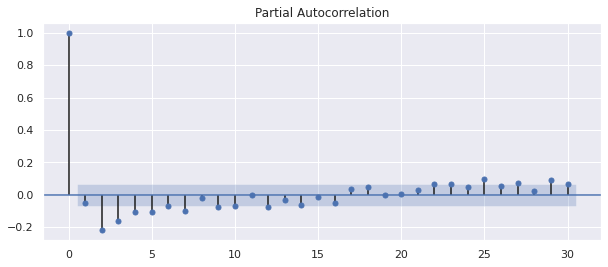

In [ ]:
diff = df.temp_min.diff(periods=1).iloc[1:]
fig1 = plot_acf(diff, lags=30)
fig2 = plot_pacf(diff, lags=30)
fig1.set_size_inches((10, 4))
fig2.set_size_inches((10, 4))
plt.show()

- `temp_mean`, `diff=0`

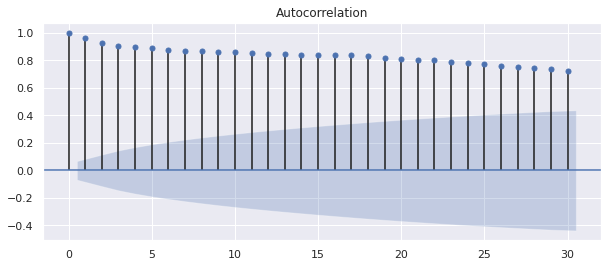

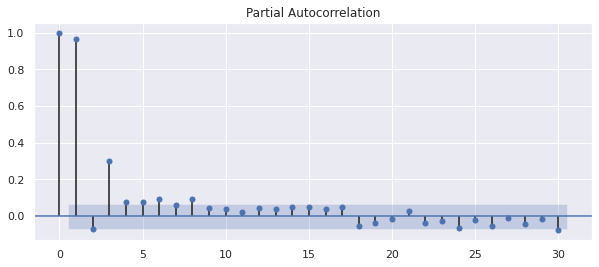

In [ ]:
fig1 = plot_acf(df.temp_mean, lags=30)
fig2 = plot_pacf(df.temp_mean, lags=30)
fig1.set_size_inches((10, 4))
fig2.set_size_inches((10, 4))
plt.show()

- `temp_mean`, `diff=1`

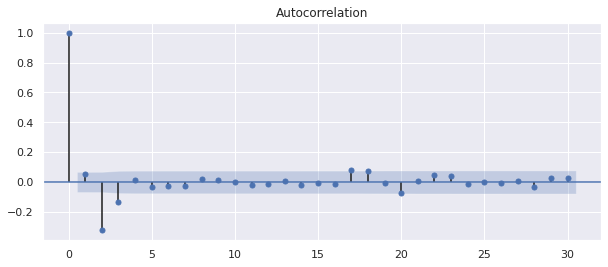

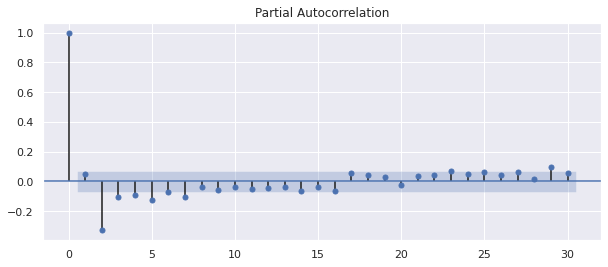

In [ ]:
diff = df.temp_mean.diff(periods=1).iloc[1:]
fig1 = plot_acf(diff, lags=30)
fig2 = plot_pacf(diff, lags=30)
fig1.set_size_inches((10, 4))
fig2.set_size_inches((10, 4))
plt.show()

## 5. 시계열 분석

S-ARIMA, Prophet, LSTM 사용

### 1. S-ARIMA

기존 ARIMA의 구성 요소
- **AR(Autoregressive)** : 현재의 시계열이 과거 관측 값들에 의해 설명하는 모델
- **MA(Moving Average)** : 시계열이 과거 오차항으로 설명하는 모델
- **I(Integrated)** : 불안정한 시계열을 정상화하는 과정

계절/주기성을 파악하기 힘든 ARIMA의 단점을 보완하기 위해, 계절 파라미터를 추가한 것이 S-ARIMA이다.

기존 파라미터 (p, d, q) + 계절 파라미터 (P, D, Q)
- p, P : AR 모델의 차수, 즉 간섭 정도를 결정
- d, D : 차분의 횟수
- q, Q : MA 모델의 차수, 즉 간섭 정도를 결정

temp_max 모델 구성

In [ ]:
# train = df.loc[df.index < '2020-01-01', 'temp_max']
# test = df.loc[df.index >= '2020-01-01', 'temp_max']

파라미터를 결정하기 위한 auto_arima 함수

각 파라미터의 max를 설정하여 모든 경우의 수를 탐색한다.

In [ ]:
# sarima = auto_arima(train, start_p=1, start_q=1,
#                     max_p=3, max_q=3, m=1, seasonal=True,
#                     d=0,
#                     max_P=5, max_Q=5, max_D=2,
#                     trace=True,
#                     error_action='ignore',
#                     suppress_warnings=True,
#                     stepwise=False)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=4725.975, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=4039.862, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=3649.382, Time=0.31 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=3502.019, Time=0.46 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=3065.210, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=3065.021, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=2998.662, Time=0.51 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=2980.226, Time=0.55 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=3066.145, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=3068.522, Time=0.57 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=2984.160, Time=0.86 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=2980.662, Time=0.68 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=3029.798, Time=0.29 sec
 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=2981.099, Time=0.92 sec
 ARIMA(3,0,2)(0,0,0)[1] intercept   : AIC=2983.094, Time=0.95 sec

Best mode

파라미터 탐색 결과 및 최적 모델

In [ ]:
# sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  699
Model:               SARIMAX(1, 0, 3)   Log Likelihood               -1484.113
Date:                Wed, 17 Feb 2021   AIC                           2980.226
Time:                        00:56:57   BIC                           3007.524
Sample:                             0   HQIC                          2990.779
                                - 699                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0518      0.064      0.806      0.420      -0.074       0.178
ar.L1          0.9964      0.004    248.721      0.000       0.989       1.004
ma.L1         -0.1771      0.035     -5.114      0.000      -0.245      -0.109
ma.L2         -0.3171      0.035     -9.017      0.000      -0.386      -0.248
ma.L3         -0.1615      0.032     -5.060      0.000      -0.224      -0.099
sigma2         4.0704      0.179     22.767      0.000       3.720       4.421
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                93.13
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.52
Prob(H) (two-sided):                  0.94   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

결정된 파라미터로 구성한 모델로 예측

In [ ]:
# pred = sarima.predict(len(test), return_conf_int=True)
# pred_val = pred[0]
# pred_val = pd.DataFrame(pred_val, index=test.index)
# r2_score(test, pred_val)

-0.23773924175966887

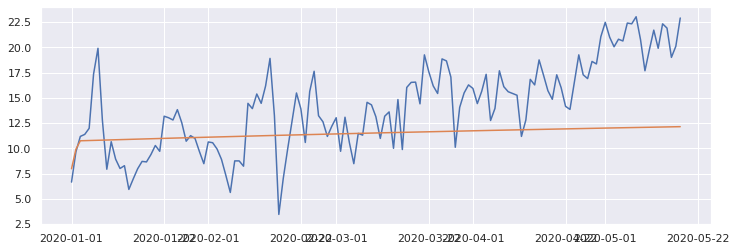

In [ ]:
# fig, ax = plt.subplots(figsize=(12, 4))
# ax.plot(test, label='True')
# ax.plot(pred_val, label='Predicted')
# plt.show()

예측 결과, 추이를 잘 반영하지 못 한다고 판단하여 아래에서 다른 모델을 적용

### 2. Prophet 모델
페이스북에서 발표한 시계열 예측 라이브러리

트렌드(growth), 계절성(seasonality), 휴일(holidays), 세 개의 요소로 이루어져 있다.


장점 :
1. 트렌드와 계절성을 유연하게 반영
2. 결측치가 있어도 무방
3. 빠른 속도
4. 파라미터의 조정이 쉬움

In [ ]:
train = df.loc[:'2019-12-31',]
test = df.loc['2020-01-01':,]

`temp_max` 예측

In [ ]:
train['y'] = train['temp_max']
train['ds'] = train.index

test['y'] = test['temp_max']
test['ds'] = test.index

In [ ]:
m_max = Prophet(seasonality_mode = 'multiplicative',
                yearly_seasonality = True, 
                weekly_seasonality = True,
                changepoint_prior_scale=0.5)
m_max.fit(train)

ParserError: ignored

In [ ]:
future_max = m_max.make_future_dataframe(periods=139)
forecast_max = m_max.predict(future_max)

In [ ]:
pred_y_max = forecast_max.yhat.values[-139:]
test_y_max = test.y

In [ ]:
pred_y_max = pd.DataFrame(pred_y_max, index=test.index)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(test_y_max, label='True')
ax.plot(pred_y_max, label='Predicted')
plt.legend()
plt.show()

`temp_min` 예측

In [ ]:
train['y'] = train['temp_min']
train['ds'] = train.index

test['y'] = test['temp_min']
test['ds'] = test.index

In [ ]:
m_min = Prophet(seasonality_mode = 'multiplicative',
                yearly_seasonality = True, 
                weekly_seasonality = True,
                changepoint_prior_scale=0.5)
m_min.fit(train)

In [ ]:
future_min = m_min.make_future_dataframe(periods=139)
forecast_min = m_min.predict(future_min)

In [ ]:
pred_y_min = forecast_min.yhat.values[-139:]
test_y_min = test.y

In [ ]:
pred_y_min = pd.DataFrame(pred_y_min, index=test.index)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(test_y_min, label='True')
ax.plot(pred_y_min, label='Predicted')
plt.legend()
plt.show()

`temp_mean` 예측

In [ ]:
train['y'] = train['temp_mean']
train['ds'] = train.index

test['y'] = test['temp_mean']
test['ds'] = test.index

In [ ]:
m_mean = Prophet(seasonality_mode = 'multiplicative',
                yearly_seasonality = True, 
                weekly_seasonality = True,
                 changepoint_prior_scale=0.5)
m_mean.fit(train)

In [ ]:
future_mean = m_mean.make_future_dataframe(periods=139)
forecast_mean = m_mean.predict(future_mean)

In [ ]:
pred_y_mean = forecast_mean.yhat.values[-139:]
test_y_mean = test.y

In [ ]:
pred_y_mean = pd.DataFrame(pred_y_mean, index=test.index)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(test_y_mean, label='True')
ax.plot(pred_y_mean, label='Predicted')
plt.legend()
plt.show()

### 3. LSTM 모델
기존 RNN 설계의 단점 (오래된 과거 시점의 학습 내용이 누락되는 점)을 보완한 모델로, 장기간 데이터에 적용이 가능하다.

기존의 시계열 분석 모델과 다르게, 추세, 계절성 등을 고려하지 않아도 된다. 

재현성을 보장하기 위해 seed를 고정

In [ ]:
def set_every_seed(seed=42):
    rd.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

set_every_seed()

`temp_max`, `temp_min`, `temp_mean`을 각각 RNN 모델이 학습 가능한 input 형태로 바꾸는 함수

In [ ]:
def data_to_input(df, col, date1, date2, timestep):
    # 1. 명시한 컬럼을 가져옴
    train = df.loc[:date1, [col]]
    test = df.loc[date2:, [col]]

    # 2. window를 생성하기 용이한 dataFrame으로 만듦
    train_df = pd.DataFrame(train, columns=[col], index=train.index)
    test_df = pd.DataFrame(test, columns=[col], index=test.index)

    # 3. 주어진 timestep에 따라 window를 생성
    # (한 행에 시작 시점으로부터 timestep까지의 데이터가 들어감)
    for s in range(1, timestep + 1):
        train_df['shift_{}'.format(s)] = train_df[col].shift(s)
        test_df['shift_{}'.format(s)] = test_df[col].shift(s)

    # 4. x and y split
    X_train = train_df.dropna().drop(col, axis=1)
    y_train = train_df.dropna()[[col]]
    X_test = test_df.dropna().drop(col, axis=1)
    y_test = test_df.dropna()[[col]]

    # 5. numpy array로 변환
    X_train = X_train.values
    X_test= X_test.values
    y_train = y_train.values
    y_test = y_test.values

    # 6. RNN의 input으로 넣기 위해 demension change (2d -> 3d)
    X_train_t = X_train.reshape(X_train.shape[0], timestep, 1)
    X_test_t = X_test.reshape(X_test.shape[0], timestep, 1)

    return X_train_t, X_test_t, y_train, y_test

`temp_max` 예측

In [ ]:
x_train_max, x_test_max, y_train_max, y_test_max = data_to_input(df, 'temp_max', '2019-12-31', '2020-01-01', 20)

모델 구성
- 합성곱 층이 입력 데이터의 1차적인 패턴을 감지 (계절성/주기성이 뚜렷하므로 이 단계에서 효율적으로 감지함)
- 두 개의 LSTM으로 시계열의 패턴을 감지
- 마지막 Dense층으로 명시된 test에 대한 예측

In [ ]:
K.clear_session()

model_max = Sequential([
                    Conv1D(filters=20, kernel_size=4, strides=2, padding='valid', 
                           input_shape=(None, 1)),
                    LSTM(20, return_sequences=True),
                    LSTM(20, return_sequences=False),
                    Dense(1)
                    ])
model_max.compile(loss='mse', optimizer='adam', metrics=['mse'])
model_max.summary()

- loss를 기준으로 early_stopping을 설정
- batch_size는 timestep과 같은 크기로 설정

In [ ]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

history = model_max.fit(x_train_max, y_train_max, batch_size=20, epochs=100, verbose=1,
                    callbacks=[early_stop])

In [ ]:
model_max.evaluate(x_test_max, y_test_max, batch_size=20, verbose=1)

In [ ]:
y_pred_max = model_max.predict(x_test_max)

`temp_min` 예측

In [ ]:
x_train_min, x_test_min, y_train_min, y_test_min = data_to_input(df, 'temp_min', '2019-12-31', '2020-01-01', 20)

In [ ]:
K.clear_session()

model_min = Sequential([
                    Conv1D(filters=20, kernel_size=4, strides=2, padding='valid', 
                           input_shape=(None, 1)),
                    LSTM(20, return_sequences=True),
                    LSTM(20, return_sequences=False),
                    Dense(1)
                    ])
model_min.compile(loss='mse', optimizer='adam', metrics=['mse'])
model_min.summary()

In [ ]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

history = model_min.fit(x_train_min, y_train_min, batch_size=20, epochs=100, verbose=1,
                    callbacks=[early_stop])

In [ ]:
model_min.evaluate(x_test_min, y_test_min, batch_size=20, verbose=1)

In [ ]:
y_pred_min = model_min.predict(x_test_min)

`temp_mean` 예측

In [ ]:
x_train_mean, x_test_mean, y_train_mean, y_test_mean = data_to_input(df, 'temp_mean', '2019-12-31', '2020-01-01', 20)

In [ ]:
K.clear_session()

model_mean = Sequential([
                    Conv1D(filters=20, kernel_size=4, strides=2, padding='valid', 
                           input_shape=(None, 1)),
                    LSTM(20, return_sequences=True),
                    LSTM(20, return_sequences=False),
                    Dense(1)
                    ])
model_mean.compile(loss='mse', optimizer='adam', metrics=['mse'])
model_mean.summary()

In [ ]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

history = model_mean.fit(x_train_mean, y_train_mean, batch_size=32, epochs=100, verbose=1,
                    callbacks=[early_stop])

In [ ]:
model_mean.evaluate(x_test_mean, y_test_mean, batch_size=32, verbose=1)

In [ ]:
y_pred_mean = model_mean.predict(x_test_mean)

예측 결과, `temp_max`, `temp_min`, `temp_mean` 모두 추세 및 변동성을 정확하게 예측하는 것을 확인할 수 있음

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y_test_max, label='True')
ax.plot(y_pred_max, label='Predicted')
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y_test_min, label='True')
ax.plot(y_pred_min, label='Predicted')
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y_test_mean, label='True')
ax.plot(y_pred_mean, label='Predicted')
plt.legend()
plt.show()

Prophet과 LSTM의 예측 결과, 

Prophet은 추이를 잘 보여주고 있고, LSTM은 모델 적합도가 다소 높은 것으로 확인됨.

## 6. 회귀분석

**LightGBM 모델**


Gradient Boosting + Tree 기반 학습 알고리즘

기존 트리 기반 알고리즘은 트리가 **수평적**으로 확장되는 반면, LightGBM은 **수직적**으로 확장된다. 

loss를 효과적으로 줄이기 위해 동작하여, 메모리를 적게 차지하고 속도가 빠르다.

Bayesian Optimization을 통한 파라미터 최적화
- `max_depth` : 트리의 최대 깊이, 모델의 적합 정도를 결정
- `num_leaves` : 트리의 잎 수
- `feature_fraction` : 트리를 학습할 때마다 선택하는 feature의 비율
- `bagging_fraction` : 트리를 학습할 때마다 사용하는 데이터의 비율
- `bagging_freq` : `bagging_fraction`을 사용하는 빈도
- `reg_alpha` : L1 정규화
- `reg_lambda` : L2 정규화


- `boosting` : boosting 종류
- `objective` : 문제의 종류

- `n_estimators` : 트리를 만드는 횟수
- `learning_rate` : 학습률

In [ ]:
def bayes_parameter_opt_lgb(train_ds,
                            init_round=15, 
                            opt_round=25, 
                            n_folds=5, 
                            random_seed=0, 
                            n_estimators=10000, 
                            learning_rate=0.01,
                            ):
    # parameters
    def lgb_eval(
                 max_depth,
                 num_leaves,
                 feature_fraction, 
                 bagging_fraction,
                 bagging_freq,
                 reg_alpha,
                 reg_lambda
                 ):
        params = {
            'boosting': 'rf', 
            'objective': 'regression', 
            'metric': 'rmse',
            'seed':42,
            }
        params['max_depth'] = int(round(max_depth))
        params['num_leaves'] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = bagging_fraction
        params['bagging_freq'] = int(bagging_freq)
        params['reg_alpha'] = reg_alpha
        params['reg_lambda'] = reg_lambda

        cv_result = lgb.cv(params, train_ds, nfold=n_folds, seed=random_seed, verbose_eval=200, stratified=False, metrics=['rmse'])

        return (-1.0 * np.array(cv_result['rmse-mean'])).max()
    

    # range 
    lgbBO = BayesianOptimization(lgb_eval, {
                                            'max_depth': (5, 20),
                                            'num_leaves' : (16, 1024),
                                            'feature_fraction': (.1, .9),
                                            'bagging_fraction': (.1, .9),
                                            'bagging_freq': (2, 10),
                                            'reg_alpha': (0, 1),
                                            'reg_lambda': (0, 1)
                                            }, random_state=42)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)

    # return best parameters
    return lgbBO

### `supply` 예측

#### Prophet 결과 기반

In [ ]:
x_train = df.loc[:'2019-12-31', ['temp_max', 'temp_min', 'temp_mean']]
y_train = df.loc[:'2019-12-31', 'supply']
x_test = pd.concat([pred_y_max, pred_y_min, pred_y_mean], axis=1)
y_test = test.supply

d_train = lgb.Dataset(x_train, y_train)
d_test = lgb.Dataset(x_test, y_test)

NameError: ignored

In [ ]:
opt_params = bayes_parameter_opt_lgb(d_train,
                                     init_round=10, opt_round=10, n_folds=5, 
                                     random_seed=42, n_estimators=1000, learning_rate=0.01)

NameError: ignored

In [ ]:
opt_params.max['params']

In [ ]:
params_1 = {'boosting': 'rf', 
            'objective': 'regression', 
            'metric': 'rmse',
            'seed': 42,
            # 최적화된 파라미터
            'bagging_fraction': 0.746717878493169,
            'bagging_freq': 4,
            'feature_fraction': 0.1781376912051071,
            'max_depth': 15,
            'num_leaves': 460,
            'reg_alpha': 0.12203823484477883,
            'reg_lambda': 0.4951769101112702
            }

최적화를 마친 파라미터를 `train` 함수에 넣고 모델 학습

In [ ]:
model_sup_pp = lgb.train(params_1, d_train, 1000, d_test, verbose_eval=100, early_stopping_rounds=100)

In [ ]:
y_pred_sup_pp = model_sup_pp.predict(x_test)
y_pred_sup_pp = pd.DataFrame({'supply':y_pred_sup_pp}, index=y_test.index)

mse = mean_squared_error(y_test, y_pred_sup_pp)
r2 = r2_score(y_test, y_pred_sup_pp)
print('mse:', mse, '  r2:', r2, '\n')

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y_test, label='True')
ax.plot(y_pred_sup_pp, label='Predicted')
plt.legend()
plt.show()

#### LSTM 결과 기반

- `x`: 위의 시계열 분석을 통해 예측한 `temp_max`, `temp_min`, `temp_mean` 컬럼들을 포함한다.
- `y`: `supply`

In [ ]:
x_train_sup = df.loc[:'2019-12-31', ['temp_max', 'temp_min', 'temp_mean']]
y_train_sup = df.loc[:'2019-12-31', 'supply']

x_test_sup = pd.DataFrame([y_pred_max.reshape(-1), y_pred_min.reshape(-1), y_pred_mean.reshape(-1)]).T
y_test_sup = df.loc['2020-01-01':, 'supply']
y_test_sup = y_test_sup[:-20,]
x_test_sup.set_index(y_test_sup.index, inplace=True)

In [ ]:
train_sup = lgb.Dataset(x_train_sup, label=y_train_sup)
test_sup = lgb.Dataset(x_test_sup, label=y_test_sup)

`rmse`, 즉 loss를 최소화하는 파라미터를 탐색

In [ ]:
opt_params = bayes_parameter_opt_lgb(train_sup,
                                     init_round=10, opt_round=10, n_folds=5, 
                                     random_seed=42, n_estimators=1000, learning_rate=0.01)

탐색 결과

In [ ]:
opt_params.max['params']

해당 파라미터 중 일부를 정수로 변환

In [ ]:
params_1 = {'boosting': 'rf', 
            'objective': 'regression', 
            'metric': 'rmse',
            'seed': 42,
            # 최적화된 파라미터
            'bagging_fraction': 0.746717878493169,
            'bagging_freq': 4,
            'feature_fraction': 0.1781376912051071,
            'max_depth': 15,
            'num_leaves': 460,
            'reg_alpha': 0.12203823484477883,
            'reg_lambda': 0.4951769101112702
            }

최적화를 마친 파라미터를 `train` 함수에 넣고 모델 학습

In [ ]:
model_sup = lgb.train(params_1, train_sup, 1000, test_sup, verbose_eval=100, early_stopping_rounds=100)

예측

In [ ]:
y_pred_sup = model_sup.predict(x_test_sup)
y_pred_sup_df = pd.DataFrame(y_pred_sup, index=y_test_sup.index)

In [ ]:
mse  = mean_squared_error(y_test_sup, y_pred_sup)
r2 = r2_score(y_test_sup, y_pred_sup)

print('Mean squared error: ', mse)
print('R2 score: ', r2)

예측 결과 시각화

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y_test_sup, label='True')
ax.plot(y_pred_sup_df, label='Predicted')
plt.legend()
plt.show()

### `smp` 예측

#### Prophet 결과 기반

`smp_max` 예측

In [ ]:
x_train = df.loc[:'2019-12-31', ['supply', 'temp_max', 'temp_min', 'temp_mean']]
y_train = df.loc[:'2019-12-31', 'smp_max']
x_test = pd.concat([y_pred_sup_pp, pred_y_max, pred_y_min, pred_y_mean], axis=1)
y_test = test.smp_max

d_train = lgb.Dataset(x_train, y_train)
d_test = lgb.Dataset(x_test, y_test)

In [ ]:
opt_params = bayes_parameter_opt_lgb(d_train,
                                     init_round=10, opt_round=10, n_folds=5, 
                                     random_seed=42, n_estimators=1000, learning_rate=0.01)

In [ ]:
opt_params.max['params']

In [ ]:
params_1 = {'boosting': 'rf', 
            'objective': 'regression', 
            'metric': 'rmse',
            'seed': 42,
            # 최적화된 파라미터
            'bagging_fraction': 0.24788356442042164,
            'bagging_freq': 10,
            'feature_fraction': 0.7201062586888917,
            'max_depth': 19,
            'num_leaves': 918,
            'reg_alpha': 0.5978999788110851,
            'reg_lambda': 0.9218742350231168
            }

In [ ]:
model_smp_max_pp = lgb.train(params_1, d_train, 1000, d_test, verbose_eval=100, early_stopping_rounds=100)

In [ ]:
y_pred_smp_max_pp = model_smp_max_pp.predict(x_test)
y_pred_smp_max_pp = pd.DataFrame({'supply':y_pred_smp_max_pp}, index=y_test.index)

mse = mean_squared_error(y_test, y_pred_smp_max_pp)
r2 = r2_score(y_test, y_pred_smp_max_pp)
print('mse:', mse, '  r2:', r2, '\n')

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y_test, label='True')
ax.plot(y_pred_smp_max_pp, label='Predicted')
plt.legend()
plt.show()

`smp_min` 예측

In [ ]:
x_train = df.loc[:'2019-12-31', ['supply', 'temp_max', 'temp_min', 'temp_mean']]
y_train = df.loc[:'2019-12-31', 'smp_min']
x_test = pd.concat([y_pred_sup_pp, pred_y_max, pred_y_min, pred_y_mean], axis=1)
y_test = test.smp_min

d_train = lgb.Dataset(x_train, y_train)
d_test = lgb.Dataset(x_test, y_test)

In [ ]:
opt_params = bayes_parameter_opt_lgb(d_train,
                                     init_round=10, opt_round=10, n_folds=5, 
                                     random_seed=42, n_estimators=1000, learning_rate=0.01)

In [ ]:
opt_params.max['params']

In [ ]:
params_1 = {'boosting': 'rf', 
            'objective': 'regression', 
            'metric': 'rmse',
            'seed': 42,
            # 최적화된 파라미터
            'bagging_fraction': 0.24788356442042164,
            'bagging_freq': 10,
            'feature_fraction': 0.7201062586888917,
            'max_depth': 19,
            'num_leaves': 918,
            'reg_alpha': 0.5978999788110851,
            'reg_lambda': 0.9218742350231168
            }

최적화를 마친 파라미터를 `train` 함수에 넣고 모델 학습

In [ ]:
model_smp_min_pp = lgb.train(params_1, d_train, 1000, d_test, verbose_eval=100, early_stopping_rounds=100)

In [ ]:
y_pred_smp_min_pp = model_smp_min_pp.predict(x_test)
y_pred_smp_min_pp = pd.DataFrame({'supply':y_pred_smp_min_pp}, index=y_test.index)

mse = mean_squared_error(y_test, y_pred_smp_min_pp)
r2 = r2_score(y_test, y_pred_smp_min_pp)
print('mse:', mse, '  r2:', r2, '\n')

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y_test, label='True')
ax.plot(y_pred_smp_min_pp, label='Predicted')
plt.legend()
plt.show()

`smp_mean` 예측

In [ ]:
x_train = df.loc[:'2019-12-31', ['supply', 'temp_max', 'temp_min', 'temp_mean']]
y_train = df.loc[:'2019-12-31', 'smp_mean']
x_test = pd.concat([y_pred_sup_pp, pred_y_max, pred_y_min, pred_y_mean], axis=1)
y_test = test.smp_mean

d_train = lgb.Dataset(x_train, y_train)
d_test = lgb.Dataset(x_test, y_test)

In [ ]:
opt_params = bayes_parameter_opt_lgb(d_train,
                                     init_round=10, opt_round=10, n_folds=5, 
                                     random_seed=42, n_estimators=1000, learning_rate=0.01)

In [ ]:
opt_params.max['params']

In [ ]:
params_1 = {'boosting': 'rf', 
            'objective': 'regression', 
            'metric': 'rmse',
            'seed': 42,
            # 최적화된 파라미터
            'bagging_fraction': 0.747305288713343,
            'bagging_freq': 4,
            'feature_fraction': 0.7806543181055711,
            'max_depth': 15,
            'num_leaves': 684,
            'reg_alpha': 0.0511980018855176,
            'reg_lambda': 0.4187819710878251
            }

최적화를 마친 파라미터를 `train` 함수에 넣고 모델 학습

In [ ]:
model_smp_mean_pp = lgb.train(params_1, d_train, 1000, d_test, verbose_eval=100, early_stopping_rounds=100)

In [ ]:
y_pred_smp_mean_pp = model_smp_mean_pp.predict(x_test)
y_pred_smp_mean_pp = pd.DataFrame({'supply':y_pred_smp_mean_pp}, index=y_test.index)

mse = mean_squared_error(y_test, y_pred_smp_mean_pp)
r2 = r2_score(y_test, y_pred_smp_mean_pp)
print('mse:', mse, '  r2:', r2, '\n')

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y_test, label='True')
ax.plot(y_pred_smp_mean_pp, label='Predicted')
plt.legend()
plt.show()

#### LSTM 결과 기반

`x` : 시계열 분석을 통해 예측한 `temp_max`, `temp_min`, `temp_mean`, 그리고 위의 회귀분석을 통해 예측한 `supply`를 포함한다.


`y` : `smp_max` / `smp_min` / `smp_mean`

`smp_max` 예측

In [ ]:
x_train_smp_max = df.loc[:'2019-12-31', ['supply', 'temp_max', 'temp_min', 'temp_mean']]
y_train_smp_max = df.loc[:'2019-12-31', 'smp_max']

x_test_smp_max = pd.DataFrame([y_pred_sup.reshape(-1), y_pred_max.reshape(-1), 
                               y_pred_min.reshape(-1), y_pred_mean.reshape(-1)]).T
y_test_smp_max = df.loc['2020-01-01':, 'smp_max']
y_test_smp_max = y_test_smp_max[:-20,]
x_test_smp_max.set_index(y_test_smp_max.index, inplace=True)

In [ ]:
train_smp_max = lgb.Dataset(x_train_smp_max, label=y_train_smp_max)
test_smp_max = lgb.Dataset(x_test_smp_max, label=y_test_smp_max)

In [ ]:
opt_params = bayes_parameter_opt_lgb(train_smp_max,
                                     init_round=10, opt_round=10, n_folds=5, 
                                     random_seed=0, n_estimators=1000, learning_rate=0.01)

In [ ]:
opt_params.max['params']

In [ ]:
params_max = {
    'boosting': 'rf', 
    'objective': 'regression', 
    'metric': 'mse',
    'seed':42,

    # 최적화된 파라미터
    'bagging_fraction': 0.26364247048639056,
    'bagging_freq': 3,
    'feature_fraction': 0.3433937943676302,
    'max_depth': 13,
    'num_leaves': 451,
    'reg_alpha': 0.36210622617823773,
    'reg_lambda': 0.6506676052501416
    }

In [ ]:
model_smp_max = lgb.train(params_max, train_smp_max, 1000, test_smp_max, verbose_eval=100, early_stopping_rounds=1000)

In [ ]:
y_pred_smp_max = model_smp_max.predict(x_test_smp_max)
y_pred_smp_max_df = pd.DataFrame(y_pred_smp_max, index=y_test_smp_max.index)

In [ ]:
mse = mean_squared_error(y_test_smp_max, y_pred_smp_max)
r2 = r2_score(y_test_smp_max, y_pred_smp_max)

print('Mean squared error: ', mse)
print('R2 score: ', r2)

`smp_min` 예측

In [ ]:
x_train_smp_min = df.loc[:'2019-12-31', ['supply', 'temp_max', 'temp_min', 'temp_mean']]
y_train_smp_min = df.loc[:'2019-12-31', 'smp_min']

x_test_smp_min = pd.DataFrame([y_pred_sup.reshape(-1), y_pred_max.reshape(-1), 
                               y_pred_min.reshape(-1), y_pred_mean.reshape(-1)]).T
y_test_smp_min = df.loc['2020-01-01':, 'smp_min']
y_test_smp_min = y_test_smp_min[:-20,]
x_test_smp_min.set_index(y_test_smp_min.index, inplace=True)

In [ ]:
train_smp_min = lgb.Dataset(x_train_smp_min, label=y_train_smp_min)
test_smp_min = lgb.Dataset(x_test_smp_min, label=y_test_smp_min)

In [ ]:
opt_params = bayes_parameter_opt_lgb(train_smp_min,
                                     init_round=10, opt_round=10, n_folds=5, 
                                     random_seed=0, n_estimators=1000, learning_rate=0.01)

In [ ]:
opt_params.max['params']

In [ ]:
params_min = {
    'boosting': 'rf', 
    'objective': 'regression', 
    'metric': 'mse',
    'seed':42,

    # 최적화된 파라미터
    'bagging_fraction': 0.22554447458683766,
    'bagging_freq': 4,
    'feature_fraction': 0.39308947463495336,
    'max_depth': 12,
    'num_leaves': 807,
    'reg_alpha': 0.2797064039425238,
    'reg_lambda': 0.5628109945722505
    }

In [ ]:
model_smp_min = lgb.train(params_min, train_smp_min, 1000, test_smp_min, verbose_eval=100, early_stopping_rounds=1000)

In [ ]:
y_pred_smp_min = model_smp_min.predict(x_test_smp_min)
y_pred_smp_min_df = pd.DataFrame(y_pred_smp_min, index=y_test_smp_min.index)

In [ ]:
mse = mean_squared_error(y_test_smp_min, y_pred_smp_min)
r2 = r2_score(y_test_smp_min, y_pred_smp_min)

print('Mean squared error: ', mse)
print('R2 score: ', r2)

`smp_mean` 예측

In [ ]:
x_train_smp_mean = df.loc[:'2019-12-31', ['supply', 'temp_max', 'temp_min', 'temp_mean']]
y_train_smp_mean = df.loc[:'2019-12-31', 'smp_mean']

x_test_smp_mean = pd.DataFrame([y_pred_sup.reshape(-1), y_pred_max.reshape(-1), 
                               y_pred_min.reshape(-1), y_pred_mean.reshape(-1)]).T
y_test_smp_mean = df.loc['2020-01-01':, 'smp_mean']
y_test_smp_mean = y_test_smp_mean[:-20,]
x_test_smp_mean.set_index(y_test_smp_mean.index, inplace=True)

In [ ]:
train_smp_mean = lgb.Dataset(x_train_smp_mean, label=y_train_smp_mean)
test_smp_mean = lgb.Dataset(x_test_smp_mean, label=y_test_smp_mean)

In [ ]:
opt_params = bayes_parameter_opt_lgb(train_smp_mean,
                                     init_round=10, opt_round=10, n_folds=5, 
                                     random_seed=0, n_estimators=1000, learning_rate=0.01)

In [ ]:
opt_params.max['params']

In [ ]:
params_mean = {
    'boosting': 'rf', 
    'objective': 'regression', 
    'metric': 'mse',
    'seed':42,

    # 최적화된 파라미터
    'bagging_fraction': 0.22554447458683766,
    'bagging_freq': 4,
    'feature_fraction': 0.39308947463495336,
    'max_depth': 12,
    'num_leaves': 807,
    'reg_alpha': 0.2797064039425238,
    'reg_lambda': 0.5628109945722505
    }

In [ ]:
model_smp_mean = lgb.train(params_mean, train_smp_mean, 1000, test_smp_mean, verbose_eval=100, early_stopping_rounds=1000)

In [ ]:
y_pred_smp_mean = model_smp_mean.predict(x_test_smp_mean)
y_pred_smp_mean_df = pd.DataFrame(y_pred_smp_mean, index=y_test_smp_mean.index)

In [ ]:
mse = mean_squared_error(y_test_smp_mean, y_pred_smp_mean)
r2 = r2_score(y_test_smp_mean, y_pred_smp_mean)

print('Mean squared error: ', mse)
print('R2 score: ', r2)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y_test_smp_max, label='True')
ax.plot(y_pred_smp_max_df, label='Predicted')
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y_test_smp_min, label='True')
ax.plot(y_pred_smp_min_df, label='Predicted')
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y_test_smp_mean, label='True')
ax.plot(y_pred_smp_mean_df, label='Predicted')
plt.legend()
plt.show()

## 7. 결과

- `temp` 속성들은 강한 계절성과 주기성을 띄어, Prophet과 RNN 모델 모두 예측을 잘 하고 있다.
- `supply`는 `temp` 속성의 영향을 강하게 받아, 예측 결과 실제 데이터와 매우 유사함을 확인할 수 있었다.
- `smp`는 기상 속성 외에 유가, 시장 추세 등 외부 요인의 영향을 받아, 예측 결과 추세 정도만 확인할 수 있었다.

## 참고

[데이터 출처(Dacon)] 

(https://www.dacon.io/competitions/official/235606/data/)


[S-ARIMA 개념 및 실습]

(https://www.youtube.com/watch?v=rdR2fNDq6v0)

[AIC 개념] 

(https://m.blog.naver.com/PostView.nhn?blogId=euleekwon&logNo=221465294530&proxyReferer=https:%2F%2Fwww.google.co.kr%2F)

[LSTM 개념] 

핸즈 온 머신러닝(도서)


(https://en.wikipedia.org/wiki/Long_short-term_memory)

[LightGBM 개념 및 파라미터 설명] 

(https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/)